# Titanic - Machine Learning from Disaster

## Import thư viện

In [1]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

## Load dữ liệu

In [2]:
# Load data 
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

## Preview data

In [3]:
print('Loaded:', train_df.shape, test_df.shape)
train_df.head()

Loaded: (891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_df.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


## Exploratory Data Analysis - EDA

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [7]:
def display_missing_data(df):
    missing = df.isna().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    percent = (missing / len(df)) * 100
    print(pd.DataFrame({'Missing Values': missing, 'Percent (%)': percent.round(2)}))

display_missing_data(train_df)

          Missing Values  Percent (%)
Cabin                687        77.10
Age                  177        19.87
Embarked               2         0.22


In [8]:
display_missing_data(test_df)

       Missing Values  Percent (%)
Cabin             327        78.23
Age                86        20.57
Fare                1         0.24


In [9]:
def best_features_for_imputation(df, target='Age', top=10):
    """
    Phân tích mối tương quan giữa 1 feature (vd: Age)
    với tất cả các feature khác trong dataframe để gợi ý 
    nên dùng cột nào để điền missing values.
    ----------------------------------------------------
    df: DataFrame
    target: tên cột muốn xem tương quan (vd 'Age')
    top: số lượng feature top đầu cần hiển thị
    """
    corrs = {}
    for col in df.columns:
        if col == target:
            continue

        try:
            # Nếu là numeric -> dùng Spearman correlation
            if np.issubdtype(df[col].dropna().dtype, np.number):
                corr = spearmanr(df[target], df[col], nan_policy='omit')[0]
            else:
                # Nếu là object -> factorize (chuyển sang mã số)
                corr = spearmanr(df[target], pd.factorize(df[col])[0], nan_policy='omit')[0]
            corrs[col] = abs(corr)
        except Exception as e:
            continue

    # Sắp xếp giảm dần
    corrs_sorted = pd.Series(corrs).sort_values(ascending=False)
    result = corrs_sorted.head(top).to_frame('Spearman Corr (|r|)')
    print(f"\nTop {top} features liên quan mạnh nhất đến '{target}':\n")
    print(result)

### Target Variable: `Survived`

In [10]:
survival_counts = train_df['Survived'].value_counts(normalize=True)

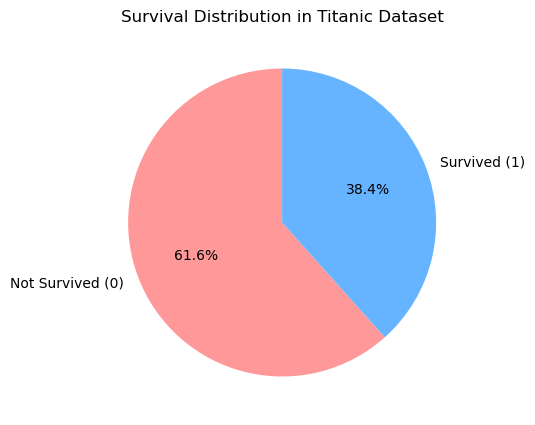

In [11]:
plt.figure(figsize=(5,5))
plt.pie(
    survival_counts,
    labels=['Not Survived (0)', 'Survived (1)'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff9999','#66b3ff']
)
plt.title('Survival Distribution in Titanic Dataset')
plt.show()

Chỉ có khoảng 38.4% hành khách sống sót trong thảm họa Titanic.

- Phân bố của các Features

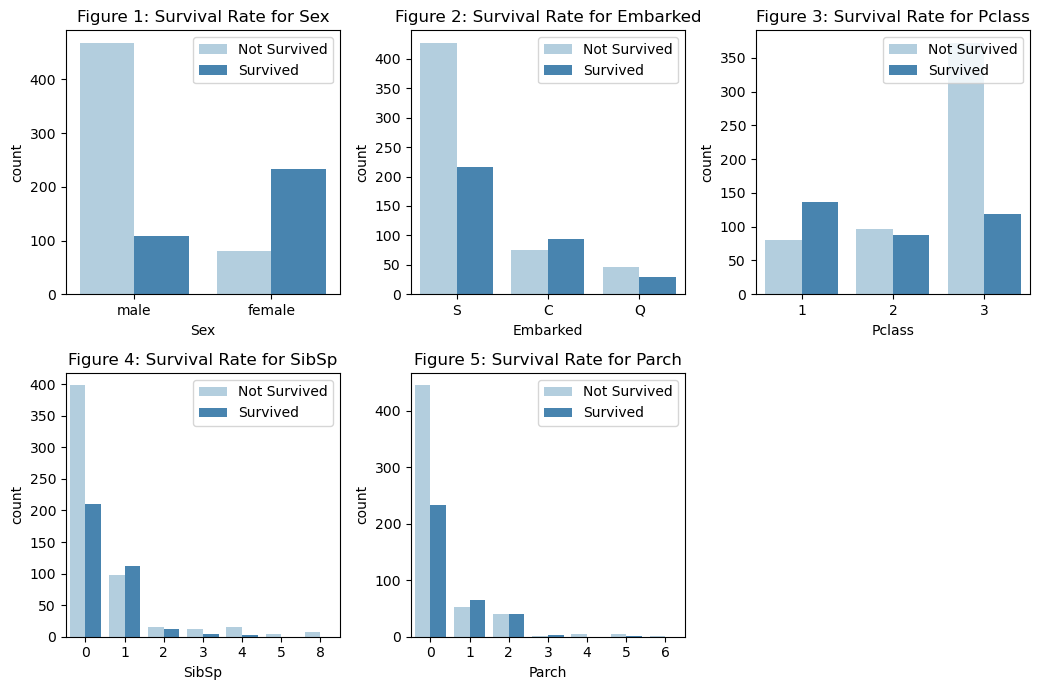

In [12]:
cols = [ 'Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch'] 

n_rows = 2
n_cols = 3

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*3.5))

for r in range(0, n_rows):
    for c in range(0, n_cols):
        i = r*n_cols + c
        if i < len(cols):
            ax_i = ax[r,c]
            sns.countplot(data=train_df, x=cols[i], hue='Survived', palette='Blues', ax=ax_i)
            ax_i.set_title(f'Figure {i+1}: Survival Rate for {cols[i]}')
            ax_i.legend(title='', loc='upper right', labels=['Not Survived', 'Survived'])
ax.flat[-1].set_visible(False)
plt.tight_layout()

**Tỉ lệ sống sót**:
- Fig 1: Tỉ lệ sống sót của nữ giới cao hơn nam giới.
- Fig 2: Đa phần mọi người đi đến Southampton, và cũng có lượng người không sống sót cao nhất.
- Fig 3: Vé hạng 1 có tỉ lệ sống sót cao hơn.
- Fig 4: Những người với `SibSp` bằng 0 hầu hết sẽ không sống sót, số lượng hành khách đi với 1-2 thành viên gia đình có cơ hội sống sót cao hơn.
- Fig 5: Những người với `Parch` bằng 0 đa phần sẽ không sống sót, số lượng hành khách đi với 1-2 thành viên gia đình có cơ hội sống sót cao hơn.

- Age

<Axes: xlabel='Age', ylabel='Count'>

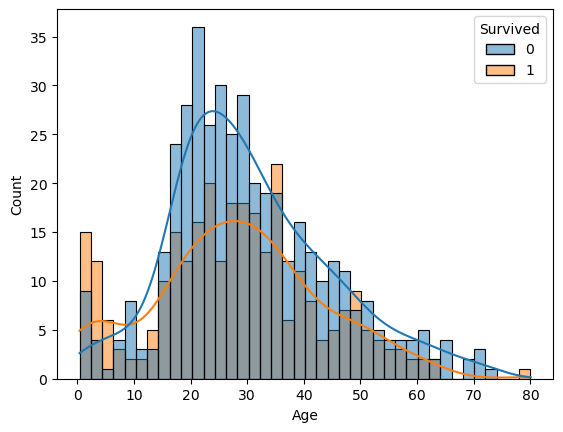

In [13]:
sns.histplot(data=train_df, x='Age', hue='Survived', bins=40, kde=True)

- Đa phần hành khách có độ tuổi từ 18-40 tuổi.
- Trẻ em có nhiều cơ hội sống sót hơn những độ tuổi khác

- Fare

<Axes: xlabel='Fare', ylabel='Count'>

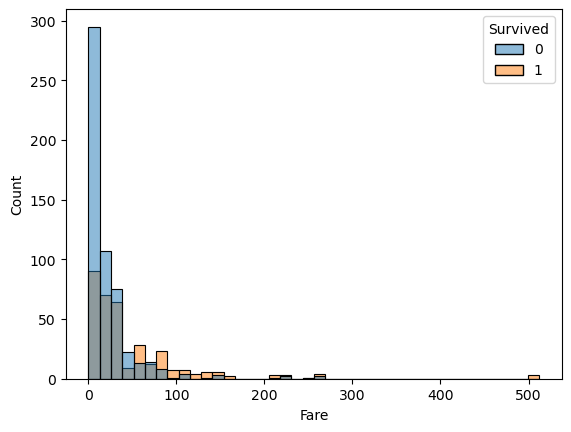

In [14]:
sns.histplot(data=train_df, x='Fare', hue='Survived', bins=40)

In [15]:
best_features_for_imputation(train_df, target='Survived', top=20)


Top 20 features liên quan mạnh nhất đến 'Survived':

             Spearman Corr (|r|)
Sex                     0.543351
Pclass                  0.339668
Fare                    0.323736
Cabin                   0.316508
Parch                   0.138266
Embarked                0.130585
SibSp                   0.088879
Age                     0.052565
Ticket                  0.039201
PassengerId             0.005007
Name                    0.005007


**Ta có các biến liên quan đến `Survived` và không bị missing:**
- Sex
- Pclass
- SibSp / Parch
- Name

## Feature Engineering (Các features không bị missing)

#### Tạo thêm các biến mới giúp mô hình phân tích chuẩn xác và mạnh hơn

- `Title`: Phản ánh giới tính, địa vị, tầng lớp xã hội.
- `IsFemale`: Giới tính nữ được ưu tiên hơn.
- `FamilySize`: Quy mô gia đình ảnh hưởng tỉ lệ sống, đi cùng thành viên gia đình có tỉ lệ sống sót cao hơn.
- `IsChild`: Đánh dấu trẻ em (dưới 12 tuổi). Trong Titanic, trẻ em thường được cứu trước theo nguyên tắc “women and children first”.
- `IsMother`: Đánh dấu phụ nữ trưởng thành có con đi cùng. Mẹ thường được ưu tiên cứu cùng con.

In [16]:
# Feature engineering
def extract_title(name):
    m = re.search(r',\s*([^\.]+)\.', name)
    return m.group(1).strip() if m else ''

title_map = {
    'Capt': 'Officer', 'Col': 'Officer', 'Major': 'Officer', 'Dr': 'Officer', 'Rev': 'Officer',
    'Don': 'Royalty', 'Sir': 'Royalty', 'Lady': 'Royalty', 'the Countess': 'Royalty', 'Jonkheer': 'Royalty', 'Dona': 'Royalty'
}

for df in [train_df, test_df]:
    # --- Title (Name) ---
    df['Title'] = df['Name'].apply(extract_title)
    df['Title'] = df['Title'].replace(['Mlle','Ms'],'Miss')
    df['Title'] = df['Title'].replace(['Mme'],'Mrs')
    df['Title'] = df['Title'].replace(title_map)
    rare = df['Title'].value_counts()[df['Title'].value_counts() < 10].index
    df['Title'] = df['Title'].replace(list(rare), 'Other')

    # --- Family (SibSp/Parch) ---
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    # --- Special groups ---
    df['IsChild'] = (df['Age'] < 12).astype(int)
    df['IsMother'] = ((df['Sex'] == 'female') & (df['Parch'] > 0) & (df['Age'] > 18) & (df['Title'] == 'Mrs')).astype(int)

## Filling missing values

In [17]:
display_missing_data(train_df)

          Missing Values  Percent (%)
Cabin                687        77.10
Age                  177        19.87
Embarked               2         0.22


- Trong file train.csv, chỉ có 2 giá trị bị thiếu (NaN) trên tổng 891 dòng —
tức là 0.2% dữ liệu → rất ít, không ảnh hưởng lớn đến phân phối.
- Chọn mode() là giá trị xuất hiện nhiều nhất trong cột để điền "giá trị đại diện" cho `Embarked`.

In [18]:
display_missing_data(test_df)

       Missing Values  Percent (%)
Cabin             327        78.23
Age                86        20.57
Fare                1         0.24


- Fare chỉ thiếu 1 giá trị → nên điền theo median.

In [19]:
best_features_for_imputation(train_df, target='Fare', top=10)


Top 10 features liên quan mạnh nhất đến 'Fare':

            Spearman Corr (|r|)
Pclass                 0.688032
Cabin                  0.532923
FamilySize             0.528907
SibSp                  0.447113
Parch                  0.410074
Survived               0.323736
Title                  0.303792
Sex                    0.259593
Ticket                 0.258902
IsMother               0.183694


- Ta thấy Pclass liên quan mạnh nhất đến `Fare` nên điền missing value của `Fare` bằng median của nhóm Pclass.

Ta thấy được trong các features có liên quan đến `Age`,:
- Parch: Hạng vé, tầng lớp xã hội. Người giàu (Pclass=1) thường lớn tuổi hơn.
- Chức danh (Mr, Miss, Dr, Master...). Phản ánh tuổi rõ nhất (Mr > Master, Miss trẻ hơn Mrs).
- Giới tính. Nam/Nữ có độ tuổi trung bình khác nhau trong từng nhóm xã hội
- Khi điền giá trị thiếu (Age), ta muốn ước lượng gần đúng độ tuổi thật của hành khách, ta chọn `Sex + Pclass + Title` là nhóm tối ưu nhất

In [20]:
# Fill missing values
for df in [train_df, test_df]:
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    
    df['Age'] = df.groupby(['Sex','Pclass','Title'])['Age'].transform(lambda x: x.fillna(x.median()))

    # --- Chuẩn hóa log ---
    df['Fare'] = np.log1p(df['Fare'])
    df['Age'] = np.log1p(df['Age'])

## Feature Engineering (Các biến khác)

In [21]:
for df in [train_df, test_df]:

    df['HasCabin'] = df['Cabin'].notna().astype(int)

    df['Age*Pclass'] = df['Age'] * df['Pclass']

    # --- Cabin / Deck ---
    df['Deck'] = df['Cabin'].astype(str).str[0]
    df['Deck'] = df['Deck'].replace('n', 'U')  # 'U' = Unknown

    # --- Interaction features ---
    df['Fare_Pclass'] = df['Fare'] / df['Pclass']

    df['TicketPrefix'] = df['Ticket'].apply(lambda x: re.split(r'\s|\.', str(x))[0])
    df['TicketPrefix'] = df['TicketPrefix'].apply(lambda x: x if x.isalpha() else 'NUM')

- `HasCabin`: Có Cabin hay không. Người có cabin → hạng vé cao → tầng lớp giàu có.
- `Deck`: Boong (deck) tàu – ký tự đầu của Cabin (A, B, C, D...). Deck thấp → gần đáy tàu → nguy hiểm hơn.
- `Age*Pclass`: Kết hợp tuổi và hạng vé – phản ánh “tầng lớp xã hội theo tuổi”.
- `Fare_Pclass`: Giá vé chia theo hạng vé.
- `TicketPrefix`: Phần đầu vé cho biết hãng tàu hoặc loại vé.

### Các features để mô hình phân tích

In [22]:
# Prepare features
feature_cols = [
    'Pclass','Sex','Age','Fare','Embarked','Title','FamilySize','IsChild','IsMother',
    'Deck','HasCabin','Fare_Pclass','Age*Pclass','TicketPrefix'
]
x = train_df[feature_cols]
y = train_df['Survived']
x_test_final = test_df[feature_cols]

### Preprocess pipeline

In [23]:
# Preprocessor (ColumnTransformer)
num_features = [
    'Age','Fare','FamilySize','Fare_Pclass','Age*Pclass'
]
cat_features = [
    'Pclass','Sex','Embarked','Title','IsChild','IsMother',
    'Deck','HasCabin','TicketPrefix'
]

num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([('num', num_transformer, num_features), ('cat', cat_transformer, cat_features)])

## Models Training

**Các mô hình dùng để phân tích**: `Logistic Regression`, `Random Forest`, `XGBoost`, `SVM`

In [24]:
# --- Khởi tạo các pipeline ---
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter=1000,random_state=42,C=1.0,solver='lbfgs'))
    ]),

    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state=42, n_jobs=-1,n_estimators=500, max_depth=5,min_samples_split=5, min_samples_leaf=3))
    ]),

    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBClassifier(random_state=42,eval_metric='logloss',n_jobs=-1,n_estimators=120,max_depth=2,learning_rate=0.08,subsample=0.6,colsample_bytree=0.6,reg_lambda=3,reg_alpha=2))
    ]),

    'SVM': Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42))
    ])
}

### Đánh giá từng model bằng cross-validation

In [25]:
cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

for name, model in models.items():
    acc = cross_val_score(model, x, y, cv=cv, scoring='accuracy').mean()
    f1 = cross_val_score(model, x, y, cv=cv, scoring='f1').mean()
    auc = cross_val_score(model, x, y, cv=cv, scoring='roc_auc').mean()

    print(f"{name} CV Results:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC:  {auc:.4f}")
    print("-" * 35)

Logistic Regression CV Results:
  Accuracy: 0.8238
  F1 Score: 0.7625
  ROC AUC:  0.8743
-----------------------------------
Random Forest CV Results:
  Accuracy: 0.8304
  F1 Score: 0.7579
  ROC AUC:  0.8695
-----------------------------------
XGBoost CV Results:
  Accuracy: 0.8238
  F1 Score: 0.7640
  ROC AUC:  nan
-----------------------------------
SVM CV Results:
  Accuracy: 0.8328
  F1 Score: 0.7635
  ROC AUC:  0.8749
-----------------------------------


### Đánh giá từng model bằng hàm train_test_split

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    y_prob = model.predict_proba(x_val)[:,1]

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"{name} Results:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC:  {auc:.4f}")
    print("-" * 35)

Logistic Regression Results:
  Accuracy: 0.8156
  F1 Score: 0.7724
  ROC AUC:  0.8880
-----------------------------------
Random Forest Results:
  Accuracy: 0.8101
  F1 Score: 0.7536
  ROC AUC:  0.9001
-----------------------------------
XGBoost Results:
  Accuracy: 0.8156
  F1 Score: 0.7755
  ROC AUC:  0.8932
-----------------------------------
SVM Results:
  Accuracy: 0.8212
  F1 Score: 0.7746
  ROC AUC:  0.8656
-----------------------------------


### Chọn mô hình tốt nhất

In [27]:
best_model = models['SVM']
best_model.fit(x, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Xuất ra file kết quả

In [28]:
# Prepare submission (predict on test)
try:
    preds = best_model.predict(x_test_final)
    submission = pd.DataFrame({
        'PassengerId': test_df['PassengerId'], 
        'Survived': preds.astype(int)
    })
    submission.to_csv('submission.csv', index=False)
    print("File 'submission.csv' created.")
except Exception as e:
    print('Không thể tạo submission tự động:', e)


File 'submission.csv' created.


In [29]:
# !jupyter nbconvert --to script titanic_test.ipynb